In [1]:
#بخش الف
!pip install pandas scikit-learn gdown

# ------------------ Libraries ------------------
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import gdown

# ------------------ Google Drive IDs ------------------
train_id = "1lIm2S9_RgwF42hO8mZuuoCn9ofiDFl03"
test_id  = "1fuQt1gGMcarbQisZ9us9IxPWAujPZlLX"

train_url = f"https://drive.google.com/uc?id={train_id}"
test_url  = f"https://drive.google.com/uc?id={test_id}"

# ------------------ Download ------------------
gdown.download(train_url, "loan_train.csv", quiet=False)
gdown.download(test_url, "loan_test.csv", quiet=False)

# ------------------ Load Data ------------------
train_df = pd.read_csv("loan_train.csv")
test_df  = pd.read_csv("loan_test.csv")

# ------------------ Remove NaN ------------------
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

# ------------------ Label Encoding ------------------
from sklearn.preprocessing import LabelEncoder

categorical_cols = [
    "Gender",
    "Married",
    "Education",
    "Self_Employed",
    "Area",
    "Status"   # فقط train
]

encoders = {}

# -------- train --------
for col in categorical_cols:
    if col in train_df.columns:
        le = LabelEncoder()
        train_df[col] = le.fit_transform(train_df[col])
        encoders[col] = le

# -------- test --------
for col in encoders:
    if col in test_df.columns:
        test_df[col] = encoders[col].transform(test_df[col])

# ------------------ Check ------------------
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

train_df.head()


Downloading...
From: https://drive.google.com/uc?id=1lIm2S9_RgwF42hO8mZuuoCn9ofiDFl03
To: c:\Users\ASUS\Desktop\AI FINAL\loan_train.csv
100%|██████████| 37.4k/37.4k [00:00<00:00, 153kB/s]
Downloading...
From: https://drive.google.com/uc?id=1fuQt1gGMcarbQisZ9us9IxPWAujPZlLX
To: c:\Users\ASUS\Desktop\AI FINAL\loan_test.csv
100%|██████████| 21.6k/21.6k [00:00<00:00, 260kB/s]

Train shape: (499, 12)
Test shape: (293, 11)


Gender  Married Dependents  Education  Self_Employed  Applicant_Income  \
0       1        0          0          0              0            584900   
1       1        1          1          0              0            458300   
2       1        1          0          0              1            300000   
3       1        1          0          1              0            258300   
4       1        0          0          0              0            600000   

   Coapplicant_Income  Loan_Amount   Term  Credit_History  Area  Status  
0                 0.0     15000000  360.0             1.0     2       1  
1            150800.0     12800000  360.0             1.0     0       0  
2                 0.0      6600000  360.0             1.0     2       1  
3            235800.0     12000000  360.0             1.0     2       1  
4                 0.0     14100000  360.0             1.0     2       1

In [2]:
#بخش ب
# =========================================================
# Install libraries (run once)
# =========================================================
!pip install pyswarms scikit-learn pandas numpy

# =========================================================
# Imports
# =========================================================
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from pyswarms.discrete import BinaryPSO

# =========================================================
# Load dataset
# =========================================================
train_df = pd.read_csv("loan_train.csv")

# =========================================================
# Drop NaN values (as required in Question 1)
# =========================================================
train_df = train_df.dropna()

# =========================================================
# Label Encoding (categorical columns)
# =========================================================
categorical_cols = [
    'Gender', 'Married', 'Education',
    'Self_Employed', 'Area', 'Dependents'
]

le = LabelEncoder()
for col in categorical_cols:
    train_df[col] = le.fit_transform(train_df[col])

# Encode target
train_df['Status'] = train_df['Status'].map({'Y': 1, 'N': 0})

# =========================================================
# Feature / Target split
# =========================================================
X = train_df.drop('Status', axis=1)
y = train_df['Status']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)


feature_names = X.columns
n_features = X.shape[1]

# =========================================================
# Fitness Function (exact formula from question)
# J = α(1 - Acc) + (1 - α)(1 - selected_features / total_features)
# =========================================================
alpha = 0.9

def fitness_function(particles):
    costs = []

    for particle in particles:
        if np.count_nonzero(particle) == 0:
            costs.append(1)
            continue

        selected = particle.astype(bool)

        X_tr = X_train.iloc[:, selected]
        X_te = X_test.iloc[:, selected]

        model = RandomForestClassifier(
            n_estimators=100,
            random_state=42
        )
        model.fit(X_tr, y_train)

        y_pred = model.predict(X_te)
        acc = accuracy_score(y_test, y_pred)

        feature_ratio = np.sum(selected) / n_features

        J = alpha * (1 - acc) + (1 - alpha) * (1 - feature_ratio)
        costs.append(J)

    return np.array(costs)

# =========================================================
# PSO parameters (FULL & CORRECT for BinaryPSO)
# =========================================================
options = {
    'c1': 0.5,
    'c2': 0.3,
    'w': 0.9,
    'k': 10,   # REQUIRED
    'p': 2     # REQUIRED
}

optimizer = BinaryPSO(
    n_particles=50,
    dimensions=n_features,
    options=options
)

# =========================================================
# Run PSO
# =========================================================
best_cost, best_position = optimizer.optimize(
    fitness_function,
    iters=100
)

# =========================================================
# Final evaluation
# =========================================================
selected_features = best_position.astype(bool)
selected_feature_names = feature_names[selected_features]

X_tr_final = X_train.iloc[:, selected_features]
X_te_final = X_test.iloc[:, selected_features]

final_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)
final_model.fit(X_tr_final, y_train)

y_pred_final = final_model.predict(X_te_final)
final_accuracy = accuracy_score(y_test, y_pred_final)

print("Selected Features:")
print(list(selected_feature_names))

print("\nNumber of selected features:", len(selected_feature_names))
print("Final Accuracy:", final_accuracy)



2026-02-12 22:53:19,628 - pyswarms.discrete.binary - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': 10, 'p': 2}
pyswarms.discrete.binary: 100%|██████████|100/100, best_cost=0.171
2026-02-12 23:01:30,364 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.17109090909090915, best pos: [1 1 1 1 1 1 1 0 1 1 1]


Selected Features:
['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Applicant_Income', 'Coapplicant_Income', 'Term', 'Credit_History', 'Area']

Number of selected features: 10
Final Accuracy: 0.82


In [3]:
# =========================================================
# GA Feature Selection (Final Clean Version)
# =========================================================
import random
import numpy as np
import pandas as pd

from deap import base, creator, tools, algorithms
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Load data
df = pd.read_csv("loan_train.csv")
df = df.dropna()

# Encoding
categorical_cols = [
    'Gender', 'Married', 'Dependents',
    'Education', 'Self_Employed', 'Area'
]

for col in categorical_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

df['Status'] = df['Status'].map({'Y': 1, 'N': 0})

X = df.drop('Status', axis=1)
y = df['Status']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

feature_names = X.columns
n_features = X.shape[1]
alpha = 0.9

# Fitness function
def evaluate(individual):
    if sum(individual) == 0:
        return (1.0,)

    selected = np.array(individual, dtype=bool)

    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train.iloc[:, selected], y_train)

    y_pred = model.predict(X_test.iloc[:, selected])
    acc = accuracy_score(y_test, y_pred)

    feature_ratio = sum(individual) / n_features
    J = alpha * (1 - acc) + (1 - alpha) * (1 - feature_ratio)

    return (J,)

# DEAP setup (clean)
if "FitnessMin" in creator.__dict__:
    del creator.FitnessMin
if "Individual" in creator.__dict__:
    del creator.Individual

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat,
                 creator.Individual, toolbox.attr_bool, n=n_features)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)

population = toolbox.population(n=50)
NGEN, CXPB, MUTPB = 50, 0.9, 0.1

best_fitness_ga = []

for gen in range(NGEN):
    offspring = algorithms.varAnd(population, toolbox, CXPB, MUTPB)

    for ind, fit in zip(offspring, map(toolbox.evaluate, offspring)):
        ind.fitness.values = fit

    population = toolbox.select(offspring, len(population))
    best = tools.selBest(population, 1)[0]
    best_fitness_ga.append(best.fitness.values[0])

# Final result
best_ind = tools.selBest(population, 1)[0]
selected = np.array(best_ind, dtype=bool)

final_model = RandomForestClassifier(n_estimators=100, random_state=42)
final_model.fit(X_train.iloc[:, selected], y_train)

final_acc = accuracy_score(
    y_test,
    final_model.predict(X_test.iloc[:, selected])
)

print("Selected Features (GA):", list(feature_names[selected]))
print("Number of selected features:", selected.sum())
print("Final Accuracy (GA):", final_acc)


Selected Features (GA): ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Applicant_Income', 'Coapplicant_Income', 'Term', 'Credit_History', 'Area']
Number of selected features: 10
Final Accuracy (GA): 0.82


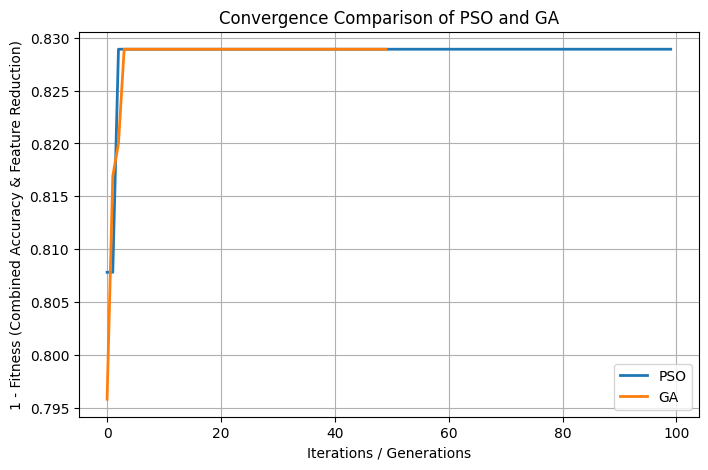

In [4]:
#بخش و
import matplotlib.pyplot as plt

# PSO: cost → accuracy
accuracy_pso = [1 - c for c in optimizer.cost_history]

# GA: best fitness per generation → accuracy
accuracy_ga = [1 - f for f in best_fitness_ga]

plt.figure(figsize=(8, 5))

plt.plot(accuracy_pso, label='PSO', linewidth=2)
plt.plot(accuracy_ga, label='GA', linewidth=2)

plt.xlabel('Iterations / Generations')
plt.ylabel('1 - Fitness (Combined Accuracy & Feature Reduction)')
plt.title('Convergence Comparison of PSO and GA')
plt.legend()
plt.grid(True)

plt.show()
